<a href="https://colab.research.google.com/github/cyndroy/DP_Skin_Cancer_Classification_using_PATE/blob/master/Normal_Skin_Cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
from PIL import Image
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torch import nn, optim
import torch.nn.functional as F
import time, os, random
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# we'll train on GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
%cd '/content/drive/My Drive/Colab Notebooks/CancerDataset'

/content/drive/My Drive/Colab Notebooks/CancerDataset


In [8]:
class SkinCancerDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None):

        benign_list = [[os.path.join(benign_path, filename),'0'] for filename in os.listdir(benign_path)] 
        malignant_list = [[os.path.join(malignant_path, filename),'1'] for filename in os.listdir(malignant_path)]
       
        self.img_list = []
        self.img_list = benign_list + malignant_list
        random.shuffle(self.img_list)

        self.transform = transform
      

    def __len__(self):
        return len(self.img_list)   

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.img_list[idx][1])
        return image, label

In [9]:
data_transforms = transforms.Compose([
    # transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

testset = SkinCancerDataset(benign_path = './data/test/benign',
                             malignant_path = './data/test/malignant' , transform = data_transforms)

validset = SkinCancerDataset(benign_path = './data/valid/benign',
                             malignant_path = './data/valid/malignant', transform = data_transforms)

len(testset),len(validset)

(584, 146)

In [17]:
#  # STUDENT
# split into train and validation set
batch_size = 20
valid_size = int(len(testset) * 0.2)
train_size = len(testset) - valid_size
student_train_subset, student_valid_subset = torch.utils.data.random_split(testset, [train_size,valid_size])

#create data loaders
student_train_loader = DataLoader(student_train_subset, batch_size=batch_size, shuffle=False, num_workers=1)
student_valid_loader = DataLoader(student_valid_subset, batch_size=batch_size, shuffle=False, num_workers=1)

len(student_train_loader), len(student_valid_loader)

(24, 6)

In [11]:

class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__() # b, 3, 32, 32
        layer1 = torch.nn.Sequential()
        layer1.add_module('conv1', torch.nn.Conv2d(3, 32, 3, 1, padding=1))
        layer1.add_module('pool1', torch.nn.MaxPool2d(2, 2))
        layer1.add_module('relu1', torch.nn.ReLU(True))
        layer1.add_module('drop1',torch.nn.Dropout(0.25)) 
        layer1.add_module('conv2', torch.nn.Conv2d(32,64, 3, 1, padding=1))
        layer1.add_module('pool2', torch.nn.MaxPool2d(2, 2)) 
        layer1.add_module('relu2', torch.nn.ReLU(True))
        layer1.add_module('drop2',torch.nn.Dropout(0.25))
        
        self.layer1 = layer1
        layer4 = torch.nn.Sequential()
        layer4.add_module('fc1', torch.nn.Linear(200704, 2))   
           
        self.layer4 = layer4

    def forward(self, x):
        conv1 = self.layer1(x)
        fc_input = conv1.view(conv1.size(0), -1)
        fc_out = self.layer4(fc_input)

        return fc_out

In [12]:
def train(n_epochs, trainloader, validloader, model, optimizer, criterion, use_cuda, save_path= None, is_not_teacher=False):
    """returns trained model"""
    # # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_lossL = []
    valid_lossL = []
    train_accL = []
    valid_accL = []

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        train_total = 0.0
        valid_correct =0.0
        valid_total = 0.0
        # train the model #
        model.train()
        for batch_idx, (data, target) in enumerate(trainloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # initialize weights to zero
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()    
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))


            # convert output probabilities to predicted class
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            train_acc = 100. * train_correct / train_total
        temp_loss = train_loss
        train_lossL.append(temp_loss.cpu().numpy())  
        
        train_accL.append(train_acc)

        # validate the model
        model.eval()
        for batch_idx, (data, target) in enumerate(validloader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            valid_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            valid_total += data.size(0)
            valid_acc = 100. * valid_correct / valid_total
        temp_loss = valid_loss
        valid_lossL.append(temp_loss.cpu().numpy())

        valid_accL.append(valid_acc) 

        # print training/validation statistics
        print('Epoch: {} \n\tTrain Loss: {:.6f} \tTrain Acc: {:.6f} \n\tValid Loss: {:.6f} \tValid Acc: {:.6f}'.format(
            epoch,train_loss,train_acc,valid_loss,valid_acc ))

        ## save the student model if validation loss has decreased
        if is_not_teacher:
          if valid_loss < valid_loss_min:
              torch.save(model.state_dict(), save_path)
              print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              valid_loss_min = valid_loss

    
    epochs = range(1,n_epochs+1)
    plt.plot(epochs, train_lossL, 'g', label='Training loss')
    plt.plot(epochs, valid_lossL, 'b', label='validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()  
            
    epochs = range(1,n_epochs+1)
    plt.plot(epochs, train_accL, 'g', label='Training acc')
    plt.plot(epochs, valid_accL, 'b', label='validation acc')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()       

    return model

In [18]:
# instantiate model and move it to GPU if available
model = SimpleCNN()
model.to(device)

#define hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters() , lr=0.001)
epochs = 13

Epoch: 1 
	Train Loss: 3.399562 	Train Acc: 54.059829 
	Valid Loss: 0.680660 	Valid Acc: 63.793103
	Validation loss decreased (inf --> 0.680660).  Saving model ...
Epoch: 2 
	Train Loss: 0.625579 	Train Acc: 66.025641 
	Valid Loss: 0.593240 	Valid Acc: 62.931034
	Validation loss decreased (0.680660 --> 0.593240).  Saving model ...
Epoch: 3 
	Train Loss: 0.539613 	Train Acc: 70.085470 
	Valid Loss: 0.616555 	Valid Acc: 68.965517
Epoch: 4 
	Train Loss: 0.522471 	Train Acc: 71.794872 
	Valid Loss: 0.536724 	Valid Acc: 76.724138
	Validation loss decreased (0.593240 --> 0.536724).  Saving model ...
Epoch: 5 
	Train Loss: 0.463237 	Train Acc: 79.059829 
	Valid Loss: 0.526202 	Valid Acc: 77.586207
	Validation loss decreased (0.536724 --> 0.526202).  Saving model ...
Epoch: 6 
	Train Loss: 0.456130 	Train Acc: 80.128205 
	Valid Loss: 0.463632 	Valid Acc: 76.724138
	Validation loss decreased (0.526202 --> 0.463632).  Saving model ...
Epoch: 7 
	Train Loss: 0.413936 	Train Acc: 79.273504 
	Valid

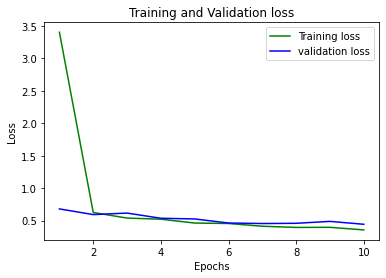

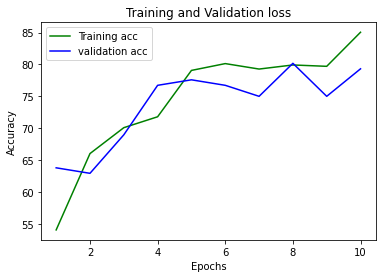

In [19]:
# Normal DL Training
epochs = 10
normal_model = train(epochs, student_train_loader, student_valid_loader, model, optimizer, criterion, True, save_path='./models/normal.pth.tar', is_not_teacher=True)


In [21]:
# Create a dataloader for the test Dataset
batch_size=16
print(len(validset))
dataloader = DataLoader(validset, batch_size=batch_size, shuffle=False)

146


In [22]:
# We set a seed for the dataset to prevent it from producing different values every time it is run
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def test(dataloader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    Y_true = []
    Y_pred = []
    
    model.eval()
    for batch_idx, (data, target) in enumerate(dataloader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)

        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        temp_pred = pred 
        
        Y_pred+=(temp_pred.cpu().numpy().transpose().tolist())
        # print(temp_pred.cpu().numpy().transpose())
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('\tTest Loss: {:.6f}'.format(test_loss))
    print('\tTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    Y_pred = sum(Y_pred,[])
    
    Y_true = [int(dataloader.dataset.img_list[i][1]) for i in range(len(dataloader.dataset.img_list)) ]
    print("CONFUSION MATRIX:\n")
    print(confusion_matrix(Y_true,Y_pred))

# call test function
print("\n=======================\nNormal Model")
test(dataloader, normal_model, criterion, True)



Normal Model
	Test Loss: 0.398668
	Test Accuracy: 80% (117/146)
CONFUSION MATRIX:

[[62 18]
 [11 55]]
